<a href="https://colab.research.google.com/github/mvgarcia/Reto-WJ/blob/main/modelo_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Preparación de los datos

Instalamos en primer lugar hiddenlayer

In [ ]:
!pip install hiddenlayer

Importamos drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importamos las librerías necesarias

In [ ]:
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from PIL import Image
import torch
from torch.autograd import Variable
import hiddenlayer as hl
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms
import torchvision
import torch.utils.data as data
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Cargamos los datos de entrenamiento y de testeo para convertir todas las imágenes a 3 canales.

In [ ]:
train_files = glob('/content/drive/MyDrive/Reto/data/train/*/*.png')
test_files = glob('/content/drive/MyDrive/Reto/data/test/*/*.png')

print(len(train_files), len(test_files))

11340 1256


Convertimos todas las imágenes del train y del test a RGB (Las que estén en blanco y negro se volverán de 3 canales)

In [ ]:
for train_file in tqdm(train_files):
  if len(np.array(Image.open(train_file)).shape) == 2:
    Image.open(train_file).convert('RGB').save('{}'.format(train_file))

In [ ]:
for test_file in tqdm(test_files):
  if len(np.array(Image.open(test_file)).shape) == 2:
    Image.open(test_file).convert('RGB').save('{}'.format(test_file))

  0%|          | 0/1256 [00:00<?, ?it/s]

Ya que vamos a utilizar ResNet, al momento de cargar los datos en el modelo debemos primero reescalarlos a la entrada de la CNN (244,244,3). Reescalamos entonces las imágenes y las convertimos a tensores.

In [ ]:
data_transform = transforms.Compose([
                 transforms.Resize((224, 224)),
                 transforms.ToTensor()
                 ])

Cargamos ahora los data loaders, tanto el de los datos de testeo como el de los de entrenamiento con un batch de 8.

In [ ]:
batch_size = 200

train_data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Reto/data/train/', transform=data_transform)
train_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Reto/data/test/', transform=data_transform)       
test_data_loader = data.DataLoader(test_data, batch_size=len(test_files), shuffle=True)

In [ ]:
for i, l in tqdm(test_data_loader):
  break
plt.imshow(i[0].permute(1,2,0))

  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

##Entrenamiento del modelo

Cargamos ResNet18 de la libreria de Torch

In [ ]:
import torch

model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
model

Using cache found in /root/.cache/torch/hub/pytorch_vision_master


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Congelamos los pesos para que no se actualicen y modificamos ResNet18 para que la salida sea de 6 clases en vez de 1000.

In [ ]:
for p in model.parameters():
    p.requires_grad = False

out_dim = 6

model.fc = torch.nn.Sequential(
  torch.nn.Linear(model.fc.in_features, out_dim)
)

model.load_state_dict(model.state_dict())
model

Definimos utilizando HiddenLayer una forma de visualizar las gráficas de entrenamiento en tiempo real

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


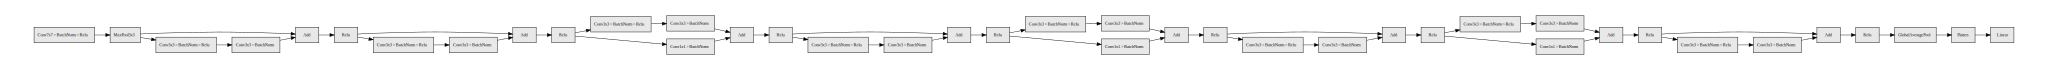

In [ ]:
hl.build_graph(model, torch.zeros([64,3,264,264]))

Finalmente, ponemos el modelo en modo de entrenamiento y entrenamos

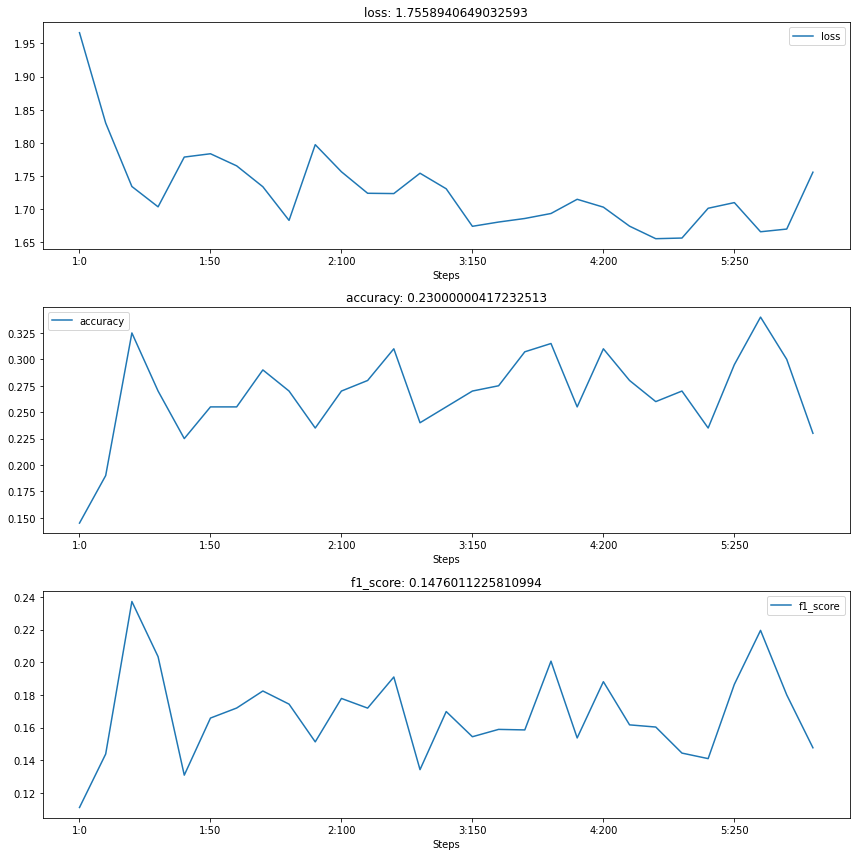

In [ ]:
#--- Definimos nuestro criterio de evaluación y el optimizador 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.1)
criterion = torch.nn.CrossEntropyLoss()


#--- Entrenamos el modelo usando únicamente 5 épocas
n_epochs = 10
model.train()

history = hl.History()
canvas = hl.Canvas()

iter = 0

for epoch in range(n_epochs):
  for batch_idx, (X_train_batch, Y_train_batch) in enumerate(train_data_loader):
    # Realiza una predicción
    Y_pred = model(X_train_batch)

    # Calcula el loss
    loss = criterion(Y_pred, Y_train_batch)
    Y_pred = torch.argmax(Y_pred, 1)

    # Calcula el accuracy
    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)
    
    # Calcula el f1_score
    f1 = f1_score(Y_train_batch, Y_pred, average='macro')

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iter%10 == 0:
        #-- Visualizamos la evolución de los score loss y accuracy
        history.log((epoch+1, iter), loss=loss, accuracy=acc, f1_score=f1)
        with canvas:
          canvas.draw_plot(history["loss"])
          canvas.draw_plot(history["accuracy"])
          canvas.draw_plot(history["f1_score"])

    iter += 1
    del X_train_batch, Y_train_batch, Y_pred

Validamos finalmente el modelo con los datos de testeo

In [ ]:
from sklearn.metrics import f1_score

model.eval()

Y_pred = model(X_test)
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

Loss:1.71, F1:0.17, Acc:0.27


Y lo guardamos para aprovecharlo eventualmente

In [ ]:
torch.save(model,open('/content/drive/MyDrive/Reto/modelo/WYJ128Batch0001LR.pt','wb'))

Y definimos la función de matriz de confusión para analizar los resultados del modelo

In [ ]:
def CM(Y_true, Y_pred, classes, lclasses=None):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  if lclasses == None:
    lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()

Llamamos a la matriz

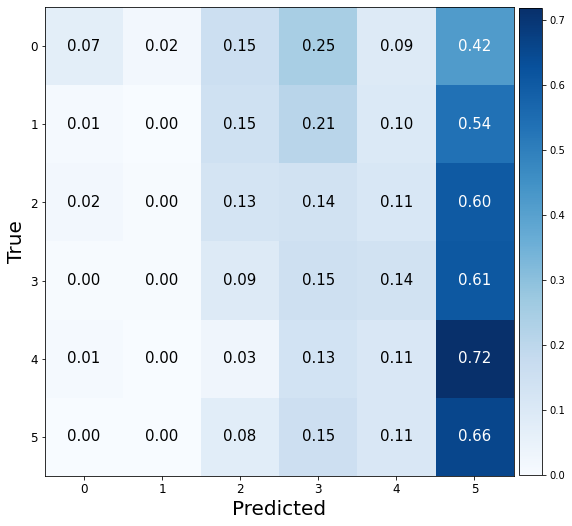

In [ ]:
 CM(Y_test, Y_pred, 6)